In [62]:
#from tensorflow_docs.vis import embed
from tensorflow import keras
#from imutils import paths

import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
#import imageio
import cv2
import os
import json
from ipywidgets import Video, Image

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Data preparation

Preparing training data

In [63]:
# We use the dataframe did in EDA notebook to build the needed new dataset for training and testing
data_df = pd. read_csv('/home/app/src/CSV/dataset_df.csv', dtype={"shot": str})

# we drop non-used columns
data_df.drop(columns=['scale_val'], inplace=True)
data_df.drop(columns = ['move_val'], inplace=True)

# Assigning path to every file
train_path = '/home/app/src/data/shot-type-dataset/trailer_v3/train/'
data_df['video_name'] = train_path + 'shot_' + data_df['movie'] + '_' + data_df['shot'] + '.mp4'
train_df = data_df[(data_df['dataset']=='train') | (data_df['dataset']=='val') ]
train_df = train_df[['video_name', 'move_label','scale_label']]
train_df = train_df.rename(columns ={'scale_label': 'tag'})

# Assigning path to every file
test_path = '/home/app/src/data/shot-type-dataset/trailer_v3/test/'
data_df['video_name'] = test_path + 'shot_' + data_df['movie'] + '_' + data_df['shot'] + '.mp4'
test_df = data_df[data_df['dataset']=='test']
test_df = test_df[['video_name', 'move_label','scale_label']]
test_df = test_df.rename(columns ={'scale_label': 'tag'})

In [69]:
# Seeing quantities of each dataset

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 25466
Total videos for testing: 8187


,Unnamed: 0,video_name,move_label,tag
20923,20923,/home/app/src/data/shot-type-dataset/trailer_v...,Static,FS
17541,17541,/home/app/src/data/shot-type-dataset/trailer_v...,Static,FS
8319,8319,/home/app/src/data/shot-type-dataset/trailer_v...,Static,MS
22539,22539,/home/app/src/data/shot-type-dataset/trailer_v...,Motion,LS
16189,16189,/home/app/src/data/shot-type-dataset/trailer_v...,Static,LS
10384,10384,/home/app/src/data/shot-type-dataset/trailer_v...,Static,CS
20897,20897,/home/app/src/data/shot-type-dataset/trailer_v...,Static,ECS
19737,19737,/home/app/src/data/shot-type-dataset/trailer_v...,Motion,MS
22278,22278,/home/app/src/data/shot-type-dataset/trailer_v...,Motion,FS
12891,12891,/home/app/src/data/shot-type-dataset/trailer_v...,Static,CS


In [70]:
# Seeing quantities of videos per label 

train_df['tag'].value_counts()

MS     5656
CS     5578
FS     5161
ECS    4868
LS     4203
Name: tag, dtype: int64

Define hyperparameters

In [71]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20

MAX_SEQ_LENGTH = 10
NUM_FEATURES = 2048

Pre-Processing

Loading videos, capturing frames and working on frame's size

In [72]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

Feature extractor

In [73]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()
print(feature_extractor.summary())

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________
None


Working on labels

In [74]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CS', 'ECS', 'FS', 'LS', 'MS']


Building embeddings (Test & Train)

In [75]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Loading embeddings

In [82]:
# path_load_embeddings= '/home/app/src/embeddings/static_shot/10k_embeddings_10F/'

# #Train
# train_data_0 = np.load(path_load_embeddings + 'train_data_embedding_0.npy')
# train_data_1 = np.load(path_load_embeddings + 'train_data_embedding_1.npy')
# train_data=(train_data_0, train_data_1)
# train_labels = np.load(path_load_embeddings + 'train_labels_embedding.npy')

# #Test
# test_data_0 = np.load(path_load_embeddings + 'test_data_embedding_0.npy')
# test_data_1 = np.load(path_load_embeddings + 'test_data_embedding_1.npy')
# test_data=(test_data_0, test_data_1)
# test_labels = np.load(path_load_embeddings + 'test_labels_embedding.npy')

Sequence model (RNN)

Training RNN and getting Test Accuracy

In [83]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"],
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/home/app/src/experiments/inceptionv3_GRU/static/model.weights_static.h5"
    filepath_log = '/home/app/src/experiments/inceptionv3_GRU/static'
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
    tensor_board = keras.callbacks.TensorBoard (filepath_log)

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint, reduce_lr, tensor_board],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # Getting predictions
    y_pred_proba = seq_model.predict([test_data[0], test_data[1]])
    y_pred = []   
    for arr in y_pred_proba:
        idx_max = np.argmax(arr)
        y_pred.append(idx_max)

    return history, seq_model, y_pred


_, sequence_model, y_pred = run_experiment()

Epoch 1/20
216/219 [============================>.] - ETA: 0s - loss: 1.1803 - accuracy: 0.5197
Epoch 1: val_loss improved from inf to 0.89557, saving model to /home/app/src/experiments/inceptionv3_GRU/static/model.weights_static.h5
219/219 [==============================] - 15s 31ms/step - loss: 1.1771 - accuracy: 0.5209 - val_loss: 0.8956 - val_accuracy: 0.6950 - lr: 0.0010
Epoch 2/20
218/219 [============================>.] - ETA: 0s - loss: 0.8514 - accuracy: 0.6810
Epoch 2: val_loss improved from 0.89557 to 0.68036, saving model to /home/app/src/experiments/inceptionv3_GRU/static/model.weights_static.h5
219/219 [==============================] - 4s 17ms/step - loss: 0.8510 - accuracy: 0.6813 - val_loss: 0.6804 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 3/20
216/219 [============================>.] - ETA: 0s - loss: 0.7353 - accuracy: 0.7322
Epoch 3: val_loss improved from 0.68036 to 0.64818, saving model to /home/app/src/experiments/inceptionv3_GRU/static/model.weights_static.h5
21

### Getting Metrics

In [84]:
%tensorboard == logdir /home/app/src/final-project-shot-type/experiments/inceptionv3_GRU/static

UsageError: Line magic function `%tensorboard` not found.


<AxesSubplot: >

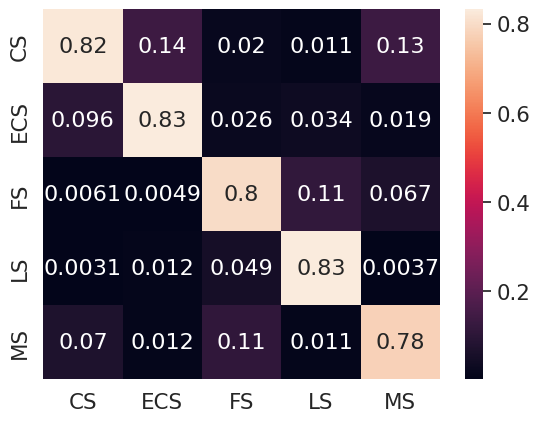

In [86]:
# Confussion Matrix
c_matrix = confusion_matrix(test_labels, y_pred , normalize='pred')
# Plotting
class_vocab = label_processor.get_vocabulary()
df_cm = pd.DataFrame(c_matrix,index = [i for i in class_vocab],
                  columns = [i for i in class_vocab])
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [87]:
# Metrics report
class_vocab = label_processor.get_vocabulary()
print(classification_report(test_labels, y_pred, target_names=class_vocab ))

              precision    recall  f1-score   support

          CS       0.82      0.69      0.75       783
         ECS       0.83      0.85      0.84       802
          FS       0.80      0.81      0.80       688
          LS       0.83      0.91      0.87       561
          MS       0.78      0.82      0.80       766

    accuracy                           0.81      3600
   macro avg       0.81      0.82      0.81      3600
weighted avg       0.81      0.81      0.81      3600



Predictions

In [88]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
real_label = test_df[test_df['video_name'] ==test_video]['tag'].iloc[0]
print(f'Real Label: {real_label}')
new_ = Video.from_file(test_video,play=True)
new_
#to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: /home/app/src/data/shot-type-dataset/trailer_v3/test/shot_tt2914386_0014.mp4


2022-11-19 20:21:45.282188: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 20:21:45.283964: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 20:21:45.284026: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-19 20:21:45.284665: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 20:21:45.284788: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  ECS: 92.25%
  CS:  7.28%
  MS:  0.26%
  LS:  0.16%
  FS:  0.05%
Real Label: ECS


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')